# Transfor Learning

-> 이미지넷으로 사전 학습된 모델을 가져와서 우리의 dataset을 추가적으로 학습시켜 사용

-> Fine Tuning : 사전 학습 모델의 가중치를 미세하게 조정하는 기법

                 새롭게 분류할 데이터를 바탕으로 사전학습 모델 가중치 일부만을
                 
                 재학습 시키거나 또는 모든 가중치를 다시 학습시킬 수 있다

                1st. 사전학습된 특징 추출기는 가져온다
                2nd. 데이터에 맞게 새로운 classifaier 를 만든다
                     -> 1. 분류기만 새로 학습
                     
                     -> 2. 분류기와 특징추출기를 살짝 학습

                     -> 3. 전부다 새로학습


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import PIL
from torch import nn, optim
from torchvision import transforms , models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os



In [3]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
# data 불러오기

train_dir = "C:/Users/admin/OneDrive/프로그래밍/딥러닝/torch_data/cats_and_dogs_filtered/cats_and_dogs_filtered/train"
val_dir = "C:/Users/admin/OneDrive/프로그래밍/딥러닝/torch_data/cats_and_dogs_filtered/cats_and_dogs_filtered/validation"

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])


train_dataset = ImageFolder(train_dir,transform=train_transforms)
val_dataset = ImageFolder(val_dir , transform=val_transforms) 


bs =32

train_data_loader = DataLoader(train_dataset,
                               batch_size=bs,
                               shuffle=True)

val_data_loader = DataLoader(val_dataset,
                             batch_size=bs,
                             shuffle=True)



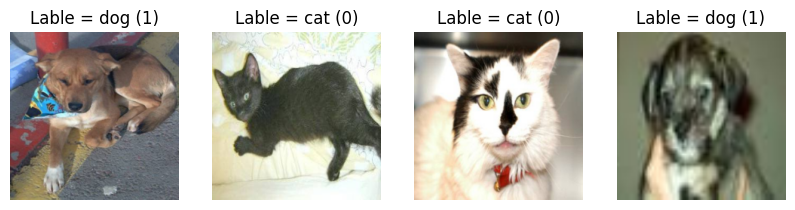

In [5]:
# data확인

img , label = next(iter(train_data_loader))

# 이미지 플로팅
fig , axes = plt.subplots(figsize = (10,4) , ncols=4)

for i in range(4):
    ax = axes[i]
    ax.imshow(img[i].permute(1,2,0)) # 텐서는 채x행x열  <-> matplotlib은 행x열x채
    if label[i] == 1:
        title = 'dog'

    else:
        title = 'cat'

    ax.set_title('Lable = {} ({})'.format(title , label[i]))
    ax.axis('off')

plt.show()



In [6]:

pretrained_model = models.resnet34(weights = models.ResNet34_Weights.DEFAULT)


print(pretrained_model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
class TransferResnet(nn.Module):

    def __init__(self,pretrained_model , feature_extractor ,n_class):
        super().__init__()
        self.n_class = n_class
        if (feature_extractor):
            for parm in pretrained_model.parameters():
                parm.require_grad = False

        
        pretrained_model.fc = nn.Sequential(
            nn.Linear(pretrained_model.fc.in_features , 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(128 , self.n_class)
        )

        self.model = pretrained_model

    
    def forward(self , x):
        x = self.model(x)
        return x

feature_extractor = False



In [8]:
model = TransferResnet(pretrained_model,feature_extractor,2)
optimizer = optim.Adam(model.parameters() , lr = 1e-6)
ciriterion = nn.CrossEntropyLoss()



In [9]:
def model_train(model , dataloader, loss_func , optimizer):
    model.train()
    model.to(device)
    train_loss_sum =train_total = train_correct = 0
    train_batch = len(dataloader)

    for img , label in dataloader:

        x_train = img.to(device)
        y_train = label.to(device)

        outputs = model(x_train)
        loss = loss_func(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 결과확인
        train_loss_sum += loss.item()

        train_total +=  y_train.size(0)
        train_correct += ((torch.argmax(outputs , 1) == y_train)).sum().item()

    avg_loss = train_loss_sum / train_batch
    avg_accuracy = 100 *train_correct / train_total

    return avg_loss ,avg_accuracy




In [10]:
train_loss = []
train_accuracy = []
epoch = 10

for ep in range(epoch):
    train_avg_loss ,train_avg_accuarcy = model_train(model , train_data_loader , ciriterion ,optimizer)

    train_loss.append(train_avg_loss)
    train_accuracy.append(train_avg_accuarcy)

    print('Epoch = {} , train_loss = {:.3f} , train_acc = {}'.format(ep , train_avg_loss , train_avg_accuarcy))



Epoch = 0 , train_loss = 0.707 , train_acc = 52.45
Epoch = 1 , train_loss = 0.630 , train_acc = 65.1
Epoch = 2 , train_loss = 0.576 , train_acc = 71.85
Epoch = 3 , train_loss = 0.517 , train_acc = 79.5
Epoch = 4 , train_loss = 0.470 , train_acc = 85.1
Epoch = 5 , train_loss = 0.425 , train_acc = 88.65
Epoch = 6 , train_loss = 0.383 , train_acc = 91.65
Epoch = 7 , train_loss = 0.344 , train_acc = 93.6
Epoch = 8 , train_loss = 0.314 , train_acc = 93.3
Epoch = 9 , train_loss = 0.289 , train_acc = 95.05


Text(0.5, 1.0, 'Training accuracy')

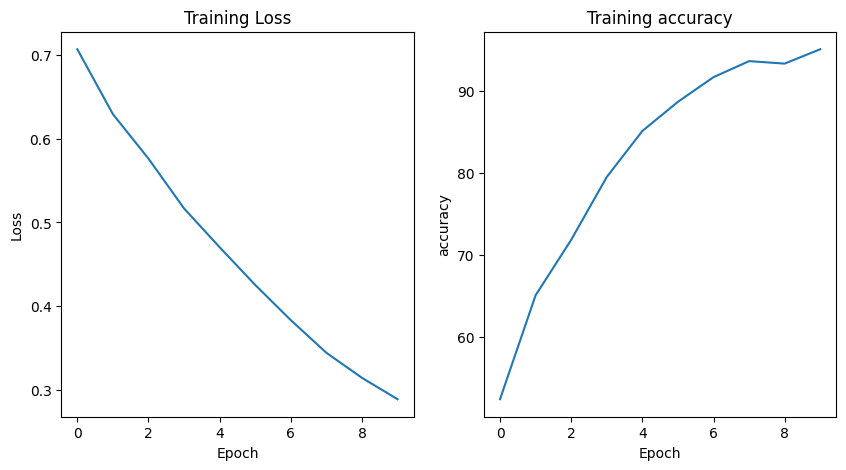

In [11]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(train_loss , label = 'Train _Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')


plt.subplot(1,2,2)
plt.plot(train_accuracy , label = 'Train _acc')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training accuracy')